In [1]:
laptop = True

if laptop:
    rootF = 'C:/Users/goethas/'
else:
    rootF = '/home/sarah/'

In [2]:
import os
import sys
from matplotlib.pyplot import *
from numpy import *
from tqdm.auto import tqdm
import itertools
import csv
import h5py
import matplotlib.gridspec as gds
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.patches as pcs
import pickle
import pandas as pd
from scipy.io import loadmat
from scipy import interpolate

# Import diverse functions
from shared.functions import fit_gaussian, get_ellipse_parameters, plot_dendrogram
from shared.save_load import *

# For clustering
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering

# Load data

### Baden data

In [3]:
Folder = rootF + '/Documents/Myopia/Data analysis/calcium_comparison/'

# Baden data
baden = loadmat(Folder + 'baden_data.mat')
# Calcium transform data
calcium = loadmat(Folder + 'calcium_conversion.mat')

chirp_stim = baden['chirp_stim'][:,0]/max(baden['chirp_stim'][:,0]) # the stimulus
chirp_stim_time = baden['chirp_stim_time'][0,:] + 2   # the stimulus times, 2 seconds later than my stim
baden_time_original = baden['chirp_time'][0,:]   # 2 seconds later than my stim
group_idx = baden['group_idx'] 
psth_euler = baden['chirp_avg'] # the average calcium traces

# Baden types : load cell types names
euler_labels_f = open(Folder + 'Baden Types');
euler_labels_f = csv.reader(euler_labels_f,delimiter=",");
euler_labels={}
c=0
for row in euler_labels_f:
    if c==0:
        stim_cond_head = row
        c=1
    else:
        euler_labels[c-1]= row
        c+=1     
        
n_baden_types = len(euler_labels)

In [4]:
print ('Euler labels :', n_baden_types, 'types')
for i in euler_labels:
    print(i, euler_labels[i][0])

Euler labels : 32 types
0 OFF local OS
1 OFF DS
2 OFF step
3 OFF slow
4 OFF alpha sustained
5 ON-OFF JAM-B
6 OFF sustained
7 OFF alpha transient
8 OFF mini alpha transient
9 ON-OFF local-edge W3
10 ON-OFF local
11 ON-OFF DS 1
12 ON-OFF DS 2
13 ON-OFF local OS
14 ON step
15 ON DS transient
16 ON local transient OS
17 ON transient
18 ON transient large
19 ON high frequency
20 ON low frequency
21 ON sustained
22 ON mini alpha
23 ON alpha
24 ON DS sustained 1
25 ON DS sustained 2
26 ON slow
27 ON constrast suppression
28 ON DS sustained 3
29 ON local sustained OS
30 OFF suppression 1
31 OFF suppression 2


### Our chirp stimulation

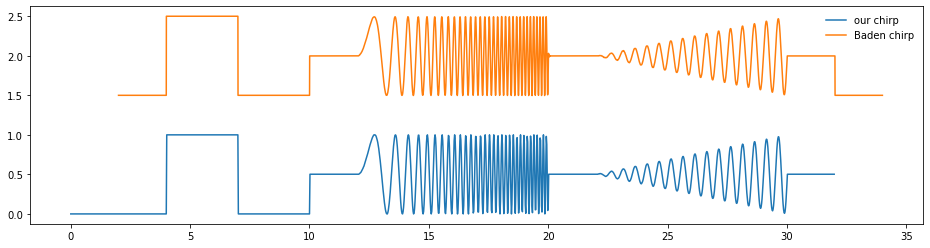

In [6]:
# Get Euler stim profile

def get_euler():
    if laptop:
        vec_path = 'E:/MEA data/exp19/STIMS/Euler/'
    else:
        vec_path = '/media/sarah/Sarah_1/MEA data/exp19/STIMS/Euler/'
    vec_path = vec_path + r"euler.vec"
    euler_vec = np.genfromtxt(vec_path)

    return (euler_vec[150:1750,1]/max(euler_vec[150:1750,1])) #return in 100ms steps

euler_vec = get_euler()

# Plot
figure(figsize = (16,4))
time_stim = np.linspace(0,32,50*32+1)[:-1]
time = np.linspace(0,32,321)[:-1]
# Our chirp
plot(time_stim, euler_vec, label='our chirp')
euler_vec.shape
euler_vec[::5].shape,time.shape
# Baden chirp
plot(chirp_stim_time ,chirp_stim+1.5, label = 'Baden chirp')
chirp_stim_time.shape, chirp_stim.shape
legend(frameon=False)

# Comparison range:
comp_range = [0.1,31.9]         # to avoid prestep effects ### why 0.1 and not 2 ?
delta_range = comp_range[1]-comp_range[0]
time_common = np.linspace(comp_range[0],comp_range[1],int(delta_range/0.05) +2)

### Euler calcium data

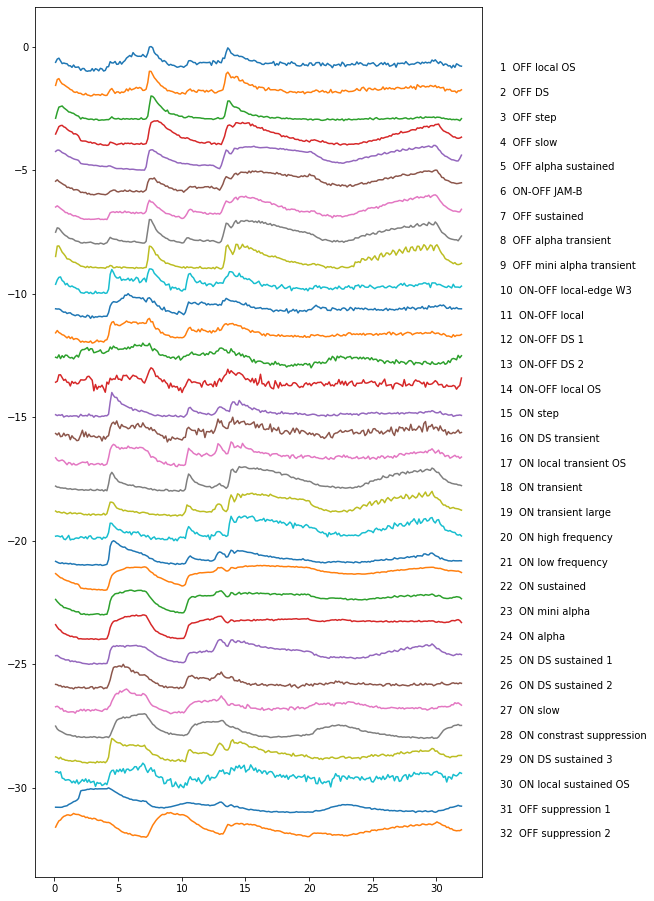

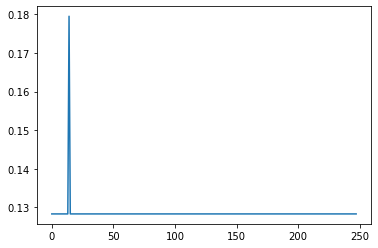

In [7]:
# Generate Baden type traces

# the two additional seconds at the end of Baden stim that will be stitched in the beginning
baden_time = baden_time_original+2
baden_first = baden_time[-15:]-32 
baden_time = np.append(baden_first,baden_time[:-15])

# we do the same for the calcium traces
Baden_types = []

figure(figsize=(8,16))

for i in np.arange(n_baden_types)+1:
    trace = np.mean(psth_euler[:,(group_idx==i)[:,0]],1)
    trace = trace-min(trace)
    trace = trace/max(trace)
    trace = np.append(trace[-15:],trace[:-15])                # I stitch las 2 s in the beggining so that it is 
                                                              #  the same as my experimental stim
    Baden_types.append(trace)
    plot(baden_time,trace-i)
    text(35,-i,str(i)+'  '+euler_labels[i-1][0])

figure()
plot(diff(baden_time))

### Clustering results

From Analyse_cell_type.ipynb

In [8]:
# experiment data
exp = 20221213
exp_path = rootF + '/Documents/Myopia/Data analysis/Blur experiments/exp' + str(exp) + '/'
clustering_data = exp_path + str(exp) + '_clustermodel'
model, psth_z = load_obj(clustering_data)

labels = model.labels_
exp_labels = np.sort(np.unique(labels))
psth_z.shape, 'Ncells  - Ndatapoints'

((56, 320), 'Ncells  - Ndatapoints')

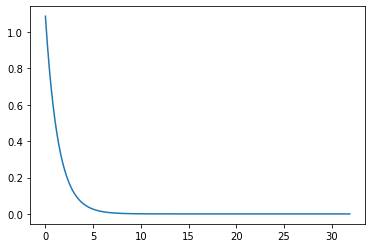

In [9]:
# functions for calcium traces

def calcium_exp(x):
    a =           0
    b =       1.086 
    c =       1.747 -1.0              ##################### changes here
    val = a+b*np.exp(-c*x)
    return val

def toCalciumLinear(time_sequence, spike_train):
    calcium_filter = calcium_exp(time_sequence);
    
    stitch3 = np.append(spike_train,[spike_train,spike_train])
    
    calcium_trace = np.convolve(stitch3, calcium_filter, 'full')[len(spike_train):len(spike_train)*2];
    calcium_trace = calcium_trace-min(calcium_trace)
    calcium_trace=calcium_trace/max(calcium_trace)
    return calcium_trace
    

calcium_filter = calcium_exp(time);
plot(time,calcium_filter)

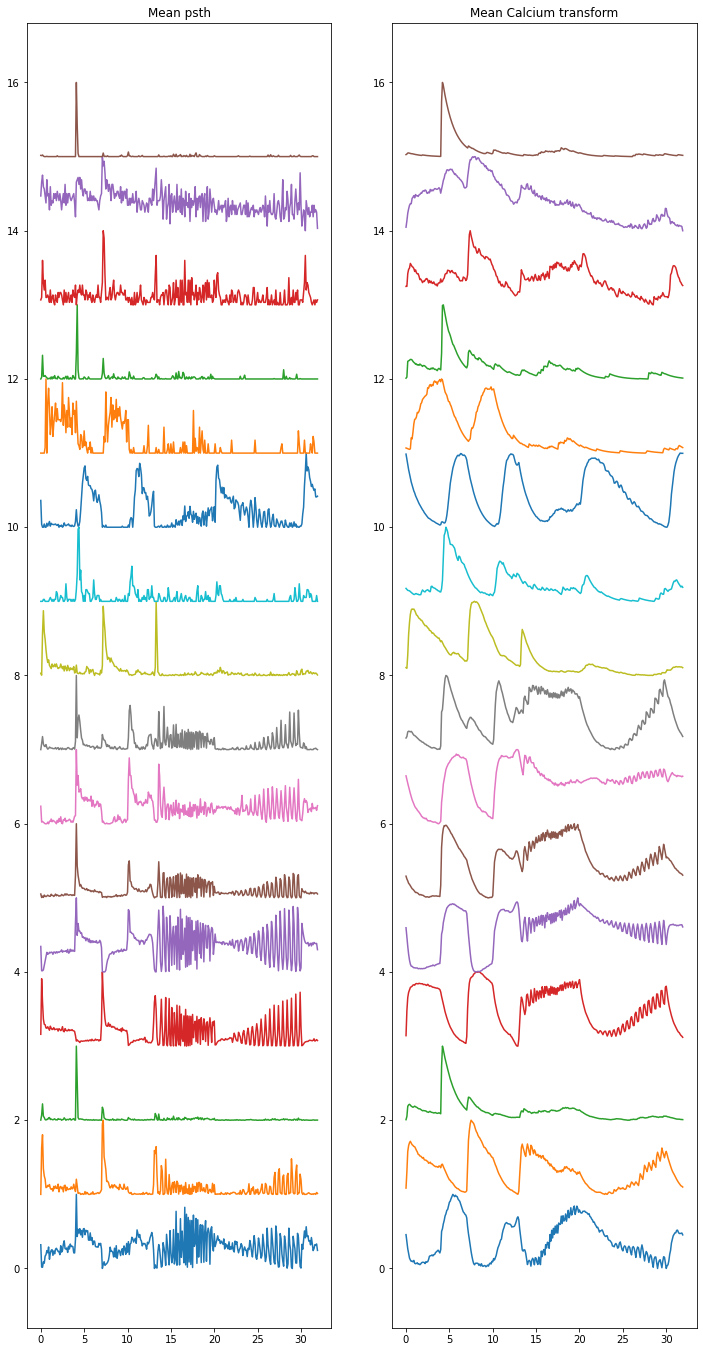

In [10]:
# Generate experiment type traces
Exp_types = []
fig = figure(figsize=(12,24))
fig.add_subplot(1,2,1)
for i in exp_labels:
    trace = np.mean(psth_z[(labels==i),:],0)
    trace = trace-min(trace)
    trace = trace/max(trace)
    Exp_types.append(trace)
    plot(time,trace+i)
    title('Mean psth')

# Experiment to calcium
Exp_types_Ca = {}
fig.add_subplot(1,2,2)
for i in exp_labels:
    trace = toCalciumLinear(time,Exp_types[i])
    Exp_types_Ca[i] = trace
    plot(time,trace+i)
    title('Mean Calcium transform')

# Correlate groups

In [11]:
# Interpolate calcium traces (Baden and transformed traces)
Baden_common = {}
for i in np.arange(n_baden_types):
    f = interpolate.interp1d(baden_time, Baden_types[i])
    Baden_common[i] = f(time_common)   # use interpolation function returned by `interp1d`

Exp_common={}
for i in exp_labels:
    f = interpolate.interp1d(time, Exp_types_Ca[i])
    Exp_common[i] = f(time_common)   # use interpolation function returned by `interp1d`

n_matches = 29
corr_table = np.zeros([len(exp_labels),n_baden_types]) 
corr_match = np.zeros([len(exp_labels),n_baden_types])
corr_match_vals = np.zeros([len(exp_labels),n_baden_types])
delta_match = np.zeros([len(exp_labels),n_baden_types+1])

# For each of our generated calcium type we compute the corr coef with each Baden type
for i in exp_labels:
    for j in np.arange(n_baden_types):
        corr_table[i,j] = np.corrcoef(Exp_common[i], Baden_common[j])[0,1]
    # For each calcium type, sort de corr coefs in descending order (max first)
    corr_match[i,:] = np.flip(np.argsort(corr_table[i,:])[-32:]) # sorted indices
    corr_match_vals[i,:] = corr_table[i,:][np.flip([np.argsort(corr_table[i,:])[-32:]])] # sorted corr coef values
    # Select the 10 larger corr coefs and store the difference with the next one
    for j in np.arange(10):
        delta_match[i,j] = corr_match_vals[i,j]-corr_match_vals[i,j+1]  

['OFF suppression 1']


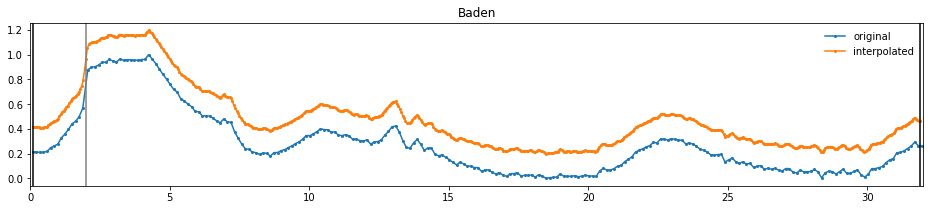

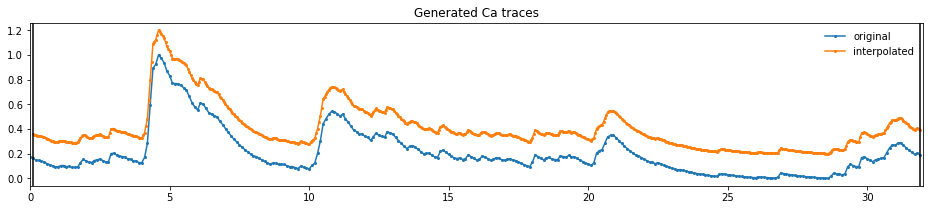

In [12]:
# Compare original and interpolated traces

# Baden traces
figure(figsize=(16,3))
idx = 30
title('Baden')
plot(baden_time, Baden_types[idx], '-o', ms=2, label = 'original')
plot(time_common, Baden_common[idx]+0.2, 'o-', ms=2, label = 'interpolated')
axvline(comp_range[0],color='k')
axvline(comp_range[1],color='k')
axvline(2,color='gray')
xlim([0,32])
legend(frameon=False)
print(euler_labels[idx])

# Generated calcium traces
figure(figsize=(16,3))
idx = 9
title('Generated Ca traces')
plot(time, Exp_types_Ca[idx], '-o', ms=2, label='original')
plot(time_common, Exp_common[idx]+0.2, 'o-', ms=2, label='interpolated')
axvline(comp_range[0],color='k')
axvline(comp_range[1],color='k')
xlim([0,32])    
legend(frameon=False)


(array([0.67150286, 0.69047688, 0.75743849, 0.7644482 , 0.76710835,
        0.7751664 , 0.81638168, 0.84392846, 0.85543315, 0.89685563]),
 0.7239576854393381,
 0.6942796478813332)

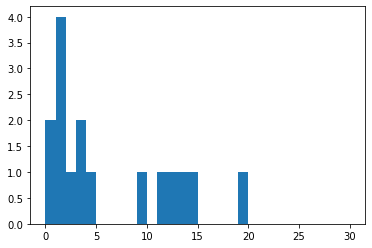

In [13]:
# Histogram of the difference between the first and second corr coef, for all cells
hist(delta_match[:,0]*100, bins=linspace(0,30,31))

np.sort(corr_match_vals[:,0])[-10:], np.median(corr_match_vals[:,0]), np.mean(corr_match_vals[:,0])

(array([0., 3., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 2., 1., 1., 2., 0., 0., 2., 0., 0., 0., 1., 1., 0.]),
 array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5, 31.5, 32.5]),
 <BarContainer object of 32 artists>)

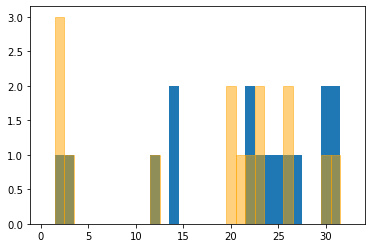

In [14]:
# Histo of the indices of first and second largest corr coefs
hist(corr_match[:,0], bins=np.arange(33)+0.5)
hist(corr_match[:,1], bins=np.arange(33)+0.5,fc='orange',ec='orange',alpha=0.5)

# Manual selection of Groups

In [15]:
fsave = exp_path + 'cells_characterization_data_with_cluster_type_' + str(exp) 
cell_data = load_obj(fsave)

fsave = exp_path + str(exp) + '_selected_cells_clustering'
selected_cells = np.array(load_obj(fsave))

match 6   0 Baden  10
match 5   0 Baden  21
match 4   0 Baden  22
match 1   0 Baden  23
match 2   0 Baden  25
match 0   0 Baden  26
match 3   0 Baden  27


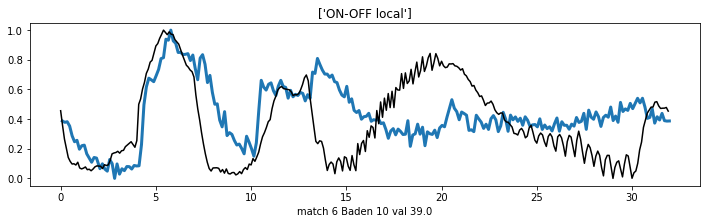

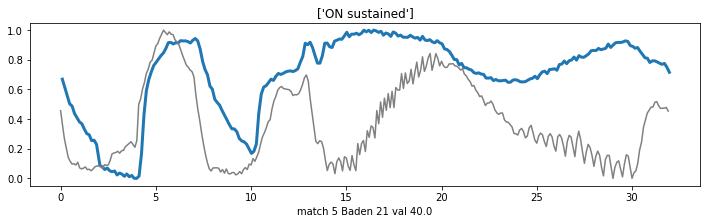

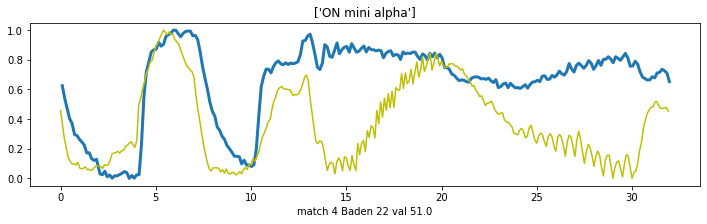

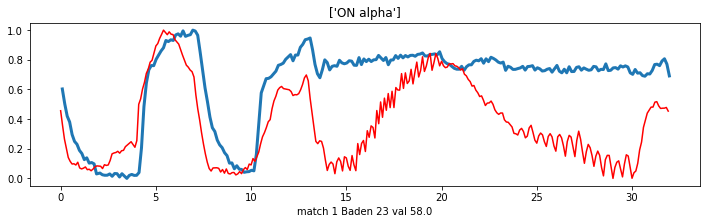

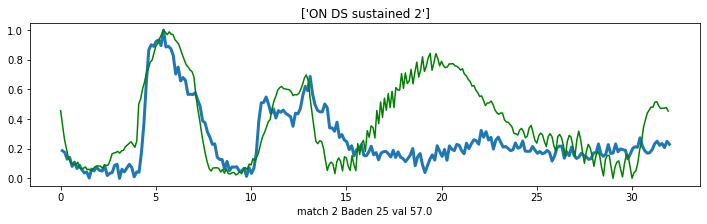

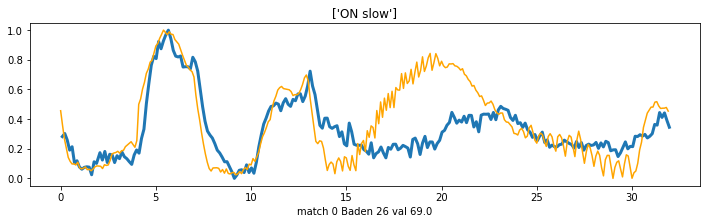

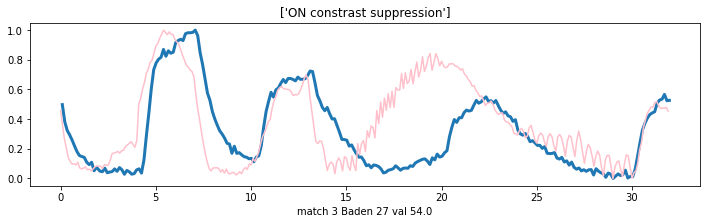

In [36]:
sel_badens = np.arange(32)

# The generated calcium trace we look at
sel_cells = [0]

n_match_sel = 7 # number of best matching Baden traces we look at for manual selection

colors = ['orange','r','g','pink','y','gray','k','c','m','darkgray','coral','gold','plum','wheat','navy']
#             0     1   2    3     4    5     6   7   8      9         10      11     12      13     14

# For each generated calcium trace we look at the first 5 best matching Baden traces
for i in sel_badens:
    Plot = False
    for j in sel_cells:
        for n_match in np.arange(n_match_sel):
            if corr_match[j, n_match]==i:
                if not(Plot): 
                    figure(figsize=(12,3))
                    # Blue: Baden type
                    plot(baden_time, Baden_types[i], lw=3)
                    title(euler_labels[i])
                    Plot=True
                if Plot:
                    # Other colors: matched calcium traces
                    plot(time, Exp_types_Ca[j], color=colors[n_match%15])
                    xlabel('match ' + str(n_match) + ' Baden ' + str(i) + ' val '+str(np.round(corr_match_vals[j,n_match]*100)) )
                    print('match', str(n_match),' ', j, 'Baden ',i)
                    
# Manually selected Baden types
manual_selection = corr_match[:,0].astype('int')

# indices are cluster groupe number, n match
manual_selection[0] = corr_match[0,0] # ON sustained
manual_selection[1] = corr_match[1,5] # OFF alpha transient (OFF slow), very confident
manual_selection[2] = corr_match[2,0] # ON step (ON-OFF DS 2), not very confident
manual_selection[3] = corr_match[3,2] # OFF alpha sustained, very confident
manual_selection[4] = corr_match[4,0] # ON alpha, confident
manual_selection[5] = corr_match[5,0] # ON mini alpha, very confident
manual_selection[6] = corr_match[6,2] # ON local transient OS (ON sustained), quite confident
manual_selection[7] = corr_match[7,2] # ON high frequency (ON DS sustained 1), not very confident
manual_selection[8] = corr_match[8,1] # OFF step, not very confident
manual_selection[9] = corr_match[9,0] # ON DS sustained 2, not confident
manual_selection[10] = corr_match[10,0] # ON contrast suppression, very confident
manual_selection[11] = corr_match[11,0] # OFF suppression 1, very confident
manual_selection[12] = corr_match[12,2] # ON step (ON DS sustained 3), confident
manual_selection[13] = corr_match[13,7] # OFF DS, confident
manual_selection[14] = corr_match[14,4] # ON-OFF local OS, not confident
manual_selection[15] = corr_match[15,0] # ON step

man_vals= np.zeros(len(exp_labels))
for i in exp_labels:
    if manual_selection[i]!=-1:
        match = np.where(manual_selection[i]==corr_match[i,:])[0][0]
        man_vals[i] = corr_match_vals[i,match]

Group 13    Baden  1 ['OFF DS']
Group 8    Baden  2 ['OFF step']
Group 3    Baden  4 ['OFF alpha sustained']
Group 1    Baden  7 ['OFF alpha transient']
Group 14    Baden  13 ['ON-OFF local OS']
Group 2    Baden  14 ['ON step']
Group 12    Baden  14 ['ON step']
Group 15    Baden  14 ['ON step']
Group 6    Baden  16 ['ON local transient OS']
Group 7    Baden  19 ['ON high frequency']
Group 5    Baden  22 ['ON mini alpha']
Group 4    Baden  23 ['ON alpha']
Group 9    Baden  25 ['ON DS sustained 2']
Group 0    Baden  26 ['ON slow']
Group 10    Baden  27 ['ON constrast suppression']
Group 11    Baden  30 ['OFF suppression 1']
counts 14


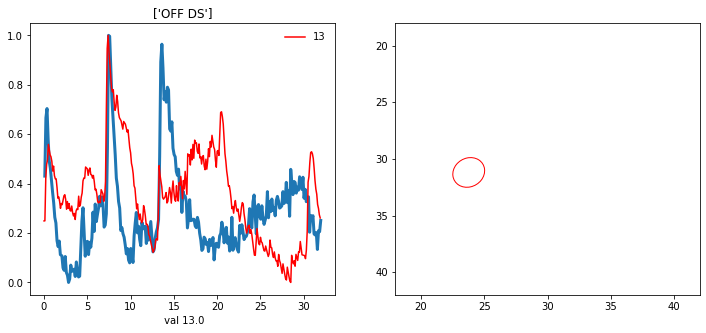

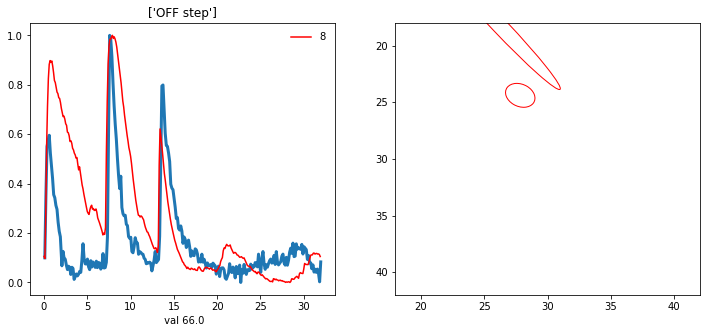

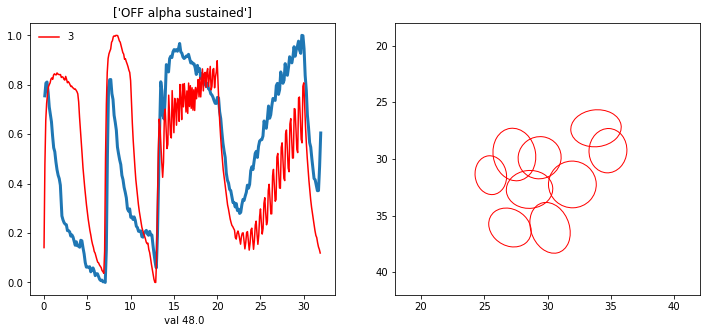

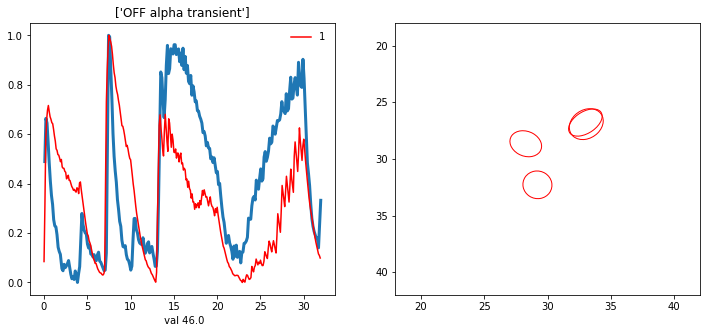

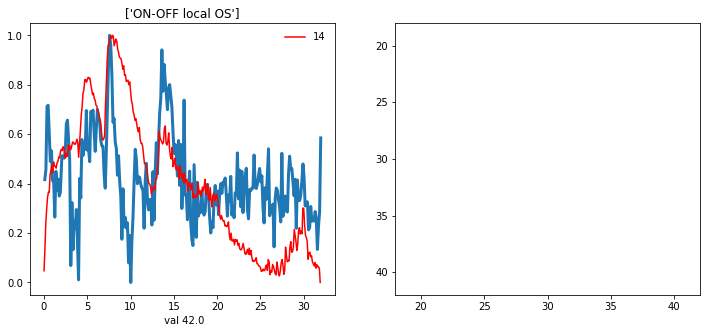

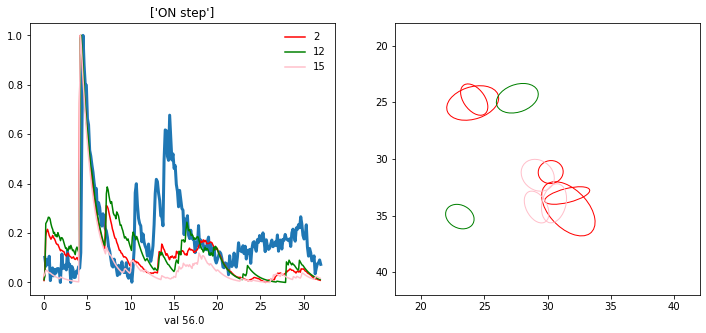

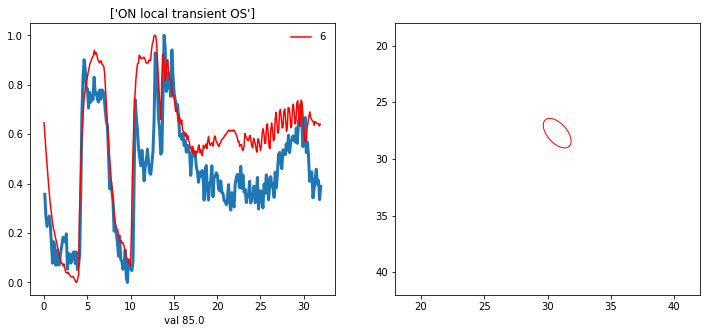

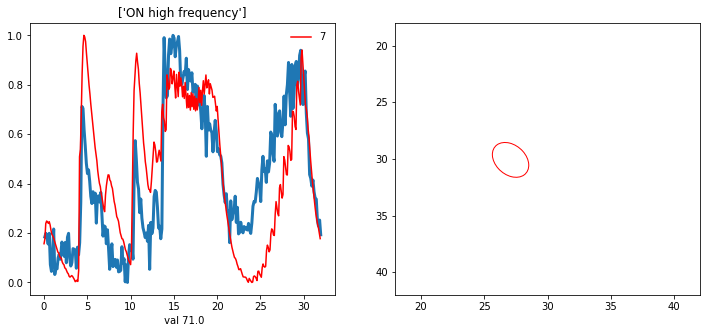

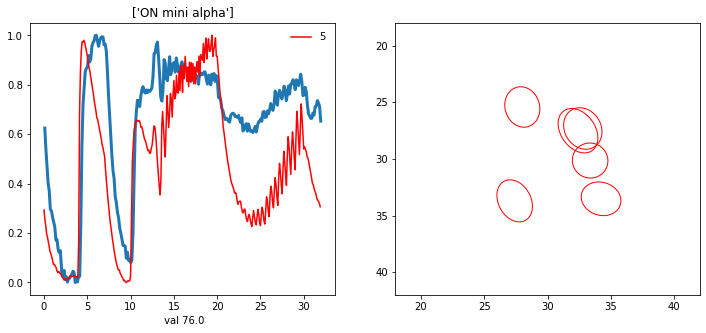

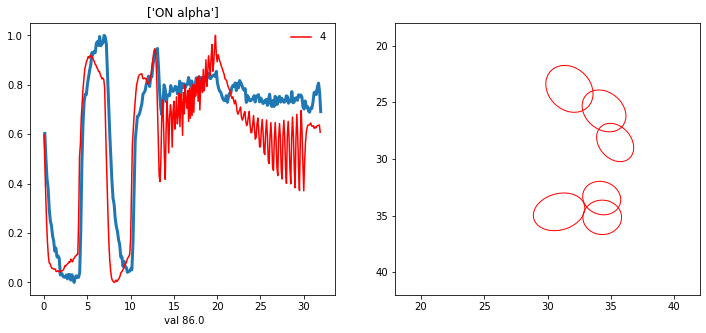

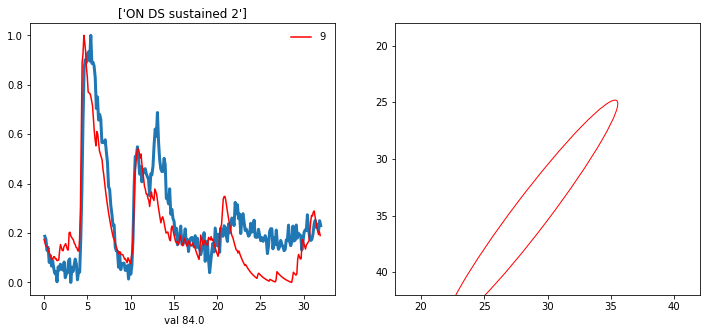

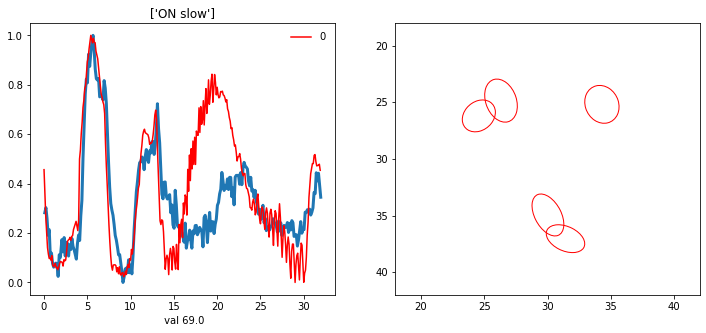

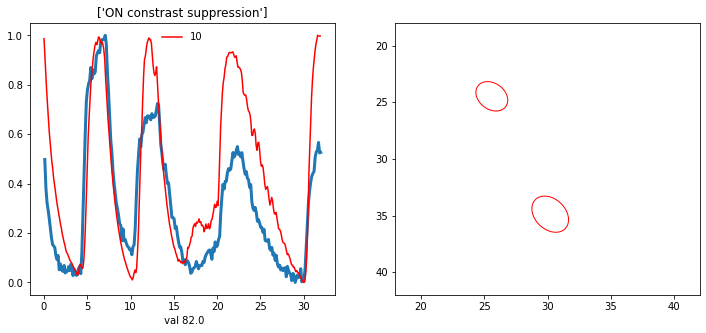

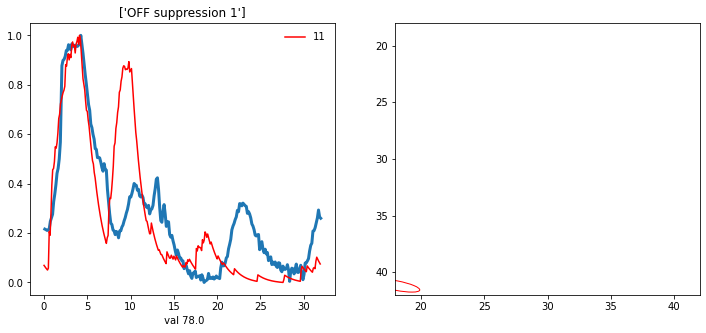

In [37]:
# Here plot the final groups

sel_badens = np.arange(32)
sel_exps = exp_labels

sel_cells = np.arange(len(manual_selection))

countg=0
for i in sel_badens:
    cc=0
    Plot=False
    for j in sel_cells:

        if manual_selection[j]==i:
            if not(Plot): 
                fig=figure(figsize=(12,5))
                ax1 = fig.add_subplot(1,2,1)
                ax2 = fig.add_subplot(1,2,2)
                ax1.plot(baden_time, Baden_types[i],lw=3)
                ax1.set_title(euler_labels[i])
                Plot=True
                countg+=1
            if Plot:
                
                ax1.plot(time, Exp_types_Ca[j], label = str(j), color=colors[cc+1])
                ax1.set_xlabel(' val '+str(np.round(man_vals[j]*100)) )#+ euler_labels[i][1])
                ax1.legend(frameon=False)
                
                clustersin = selected_cells[np.where((model.labels_==j))[0]]
                cc+=1
                for c in clustersin:
                    x_fit, y_fit, fitted_spatial_sta , parameters = fit_gaussian(cell_data[str(c)]["spatial_sta"])
                    x0, y0, width, height, angle = get_ellipse_parameters(parameters, factor=1)
                    xy = (x0, y0)
                    ellipse = pcs.Ellipse(xy, width, height, angle=angle, fill=False, color = colors[cc],lw=1)
                    ax2.add_patch(ellipse)
#                     ax2.plot(cell_data[c]['ellipseMat'][0]   , cell_data[c]['ellipseMat'][1] ,color=colors[cc] ,lw=0.5)#,lw=10)    #rotated ellipse
                ax2.set_xlim(18,42)
                ax2.set_ylim(42,18)

                    
                print('Group',j, '   Baden ',i, euler_labels[i])
print('counts' ,countg)

### New cluster labels

In [38]:
new_labels = np.zeros(len(model.labels_))
for j in np.arange(len(model.labels_)):
    new_labels[j] = manual_selection[model.labels_[j]]

# here assign label to each cluster
Dic_labels={}
for i in np.arange(len(new_labels)):
    if new_labels[i]!=-1:
        Dic_labels.update({list(selected_cells)[i]: euler_labels[new_labels[i]]})
#--------------------
for c in sorted(list(Dic_labels.keys())):
     print('Clus ',c, '   Baden ',Dic_labels[c])

Clus  19    Baden  ['OFF alpha sustained']
Clus  27    Baden  ['ON constrast suppression']
Clus  30    Baden  ['ON slow']
Clus  39    Baden  ['OFF alpha sustained']
Clus  52    Baden  ['ON step']
Clus  55    Baden  ['ON step']
Clus  66    Baden  ['ON step']
Clus  67    Baden  ['ON mini alpha']
Clus  79    Baden  ['OFF alpha transient']
Clus  84    Baden  ['ON step']
Clus  98    Baden  ['ON mini alpha']
Clus  105    Baden  ['ON step']
Clus  109    Baden  ['ON step']
Clus  113    Baden  ['ON slow']
Clus  145    Baden  ['OFF alpha sustained']
Clus  173    Baden  ['ON step']
Clus  180    Baden  ['ON step']
Clus  182    Baden  ['ON slow']
Clus  201    Baden  ['ON step']
Clus  205    Baden  ['ON constrast suppression']
Clus  207    Baden  ['ON mini alpha']
Clus  232    Baden  ['ON DS sustained 2']
Clus  294    Baden  ['ON step']
Clus  295    Baden  ['OFF alpha sustained']
Clus  310    Baden  ['ON step']
Clus  323    Baden  ['OFF suppression 1']
Clus  333    Baden  ['ON high frequency']
Clus 

C:\Users\goethas\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\goethas\Anaconda3\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\goethas\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\goethas\Anaconda3\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\goethas\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\goethas\Anaconda3\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\goethas\Anaconda3\lib\site-package

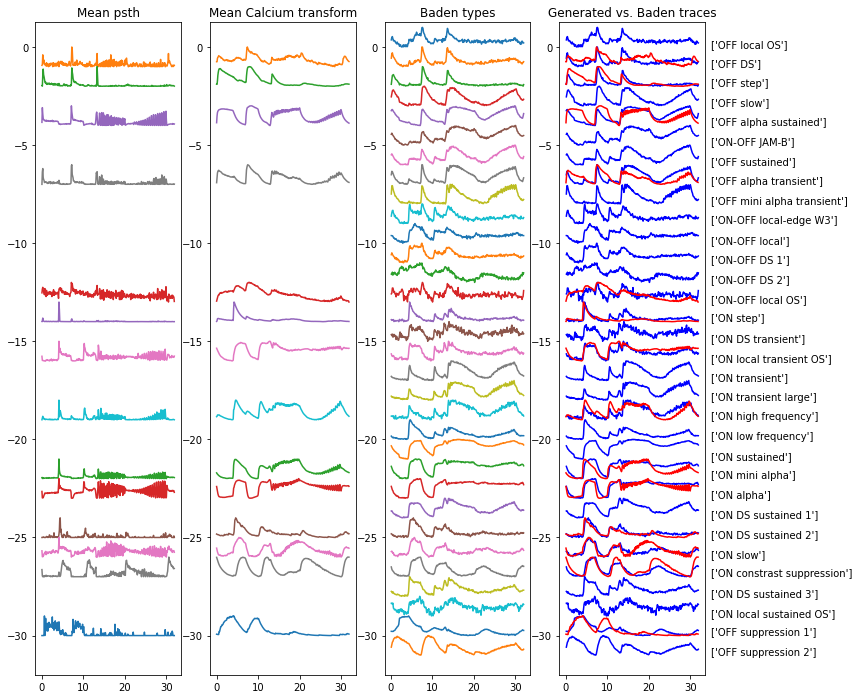

In [39]:
# Generate new experiment type traces
Exp_sorted_types = []

fig = figure(figsize=(12,12))

# Average MEA traces 
fig.add_subplot(1,4,1)
for i in euler_labels.keys():
    trace = np.mean(psth_z[(new_labels==i),:],0)
    trace = trace-min(trace)
    trace = trace/max(trace)
    Exp_sorted_types.append(trace)
    plot(time,trace-i)
    title('Mean psth')
    ylim([-32,1.25])
    
# Experiment to calcium
Exp_sorted_types_Ca = {}
fig.add_subplot(1,4,2)
for i in euler_labels.keys():
    trace = toCalciumLinear(time,Exp_sorted_types[i])
    Exp_sorted_types_Ca[i] = trace
    plot(time,trace-i)
    title('Mean Calcium transform')
    ylim([-32,1.25])
    
# Baden calcium traces
fig.add_subplot(1,4,3)
for i in euler_labels.keys():
    plot(baden_time,Baden_types[i]-i)
    ylim([-32,1.25])
    title('Baden types')

# Comparison
fig.add_subplot(1,4,4)
for i in euler_labels.keys():
    plot(baden_time,Baden_types[i]-i,'b')
    plot(time,Exp_sorted_types_Ca[i]-i,'r')
    text(35,-i,euler_labels[i])
    ylim([-32,1.25])
    title('Generated vs. Baden traces')

# Create a summary figure for each cluster type

In [40]:
for icluster in range(len(euler_labels))[0:]:
    idx_cluster = np.where(new_labels==icluster)[0]
    print(len(idx_cluster))
    
    if len(idx_cluster) > 0:

        gs = gds.GridSpec(len(idx_cluster)+3,6)

        if len(idx_cluster)<7:
            yspan = 2
        else:
            yspan=-2
        fig=figure(figsize=(14,(len(idx_cluster)+yspan)*1.75))
        plt.suptitle("Cell group {}   {}   {} cells".format(icluster,euler_labels[icluster], len(idx_cluster)),size=24)

        # Loop cells in cluster
        line = 2
        STAs=np.zeros(40)
        STAcount=0
        waves=np.zeros(101)
        wavecount=0
        
        for index in sorted(idx_cluster):
            cell_nb = str(list(selected_cells)[index])

            # Plot temp STA
            ax= subplot(gs[line+1,1])

            ax.set_ylim([-4,4])
            ax.axis("off")
            ax.set_aspect(0.075)
            ax.step(np.linspace(-40/30,0,40),cell_data[cell_nb]["temporal_sta"],'k',lw=3)
            polarity = cell_data[cell_nb]["polarity"]
            ax.set_title('Cluster ' + str(cell_nb) + '  Polarity '+polarity)
            ax.axhline(0,color='k',lw=0.5)

            STAs+=cell_data[cell_nb]["temporal_sta"]
            STAcount+=1

            # Plot temp STA avg
            ax= subplot(gs[0,1])

            ax.set_title('Temp STA')
            ax.set_ylim([-4,4])
            ax.plot(np.linspace(-40/30,0,40),cell_data[cell_nb]["temporal_sta"],lw=0.5)
            ax.axhline(0,color='k',lw=0.5)
            ax.set_xlabel('Time(s)')

            # plot Spatial STA
            ax= subplot(gs[line+1,0])
            ax.imshow(cell_data[cell_nb]["spatial_sta"], cmap='gray',interpolation='gaussian')
            ax.set_xlim(16,44)
            ax.set_ylim(44,16)
            ax.set_aspect('equal')
            ax.set_xticks([])
            ax.set_yticks([])

            #plot waveform
            ax= subplot(gs[line+1,2])
            wave = cell_data[cell_nb]["templates"]/abs(np.min(cell_data[cell_nb]["templates"]))
            ax.plot(wave,'r')
            ax.axis("off")
            ax.set_ylim([-1.25,1.25])
            waves+=wave
            wavecount+=1

            ax= subplot(gs[0,2])
            ax.plot(wave,lw=0.5)
            ax.axis("off")
            ax.set_ylim([-1.25,1.25])

            # plot Euler
            ax= subplot(gs[line+1,3:])
#             cell_index=list(selected_cells).index(cell_nb)
            ax.plot(np.linspace(0,32,800),cell_data[cell_nb]["psth"])
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.set_xticks([])
            plt.locator_params(axis="y", nbins=3)

            # plot Ellipse
            x_fit, y_fit, fitted_spatial_sta , parameters = fit_gaussian(cell_data[cell_nb]["spatial_sta"])

            x0, y0, width, height, angle = get_ellipse_parameters(parameters, factor=1)
            xy = (x0, y0)

            ax= subplot(gs[line+1,0])
            ellipse = pcs.Ellipse(xy, width, height, angle=angle, fill=False, color='r',lw=1)
            ax.add_patch(ellipse)

            ax= subplot(gs[0:2,0])
            ellipse = pcs.Ellipse(xy, width, height, angle=angle, fill=False, color='k',lw=1)
            ax.add_patch(ellipse)

            line+=1

        # avg STA
        STAs=STAs/STAcount
        ax= subplot(gs[0,1])
        ax.plot(np.linspace(-40/30,0,40),STAs,'k',lw=2)
        ax.set_ylim([-4,4])
        ax.set_aspect(0.075)
        ax.axis("off")

        # avg wave
        waves=waves/wavecount
        ax= subplot(gs[0,2])
        ax.set_title('Waveform')

        ax.plot(waves,'r',lw=2)
        ax.set_ylim([-1.25,1.25])
        #ax.set_aspect(0.075)
        ax.axis("off")

        # size ellipses
        ax= subplot(gs[0:2,0])

        ax.set_title('Ellipses')
        ax.set_xlim(16,44)
        ax.set_ylim(44,16)
        ax.set_aspect('equal')
        ax.set_xticks([])
        ax.set_yticks([])

        # mean psth
        ax= subplot(gs[0,3:])
        ax.set_title('Euler psth')

        ax.plot(np.linspace(0,32,320),np.mean(psth_z[idx_cluster,:], 0),'g')
        ax.axis("off")

        # mean Ca trace + comparison
        ax= subplot(gs[1,3:])
        ax.text(-9,1,'Calcium traces')
        ax.axis("off")

        plot(time,Exp_sorted_types_Ca[icluster] ,'g')
        plot(baden_time,Baden_types[icluster],'r')

        # plot euler stim
        euler_vec= get_euler()
        ax= subplot(gs[2,3:])
        ax.plot(time_stim,euler_vec, color='k')
        ax.set_yticks([])
        ax.set_ylim([-0.25,1.25])
        ax.set_xlabel('Time(s)')
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['top'].set_visible(False)

        ax= subplot(gs[2,2])
        ax.text(0.5,0.5 ,"Chirp stimulus profile")
        ax.axis("off")
        
        ### Save figure

        PDF_folder = rootF + 'Documents/Myopia/Data analysis/Blur experiments/exp' + str(exp) + '/RGC typing/Baden types/'
        fsave = PDF_folder +'exp'+ str(exp) +'_badentype' +str(icluster) 

        fig.savefig(fsave+'.png',format='png',dpi=250)
        close(fig)  


0
1
3
0
10
0
0
4
0
0
0
0
0
1
12
0
2
0
0
2
0
0
6
6
0
1
5
2
0
0
1
0


# SAVE DATA

In [41]:
# Save average Ca traces for each type
fsave = exp_path + str(exp) + '_celltype_Ca_traces'
save_obj(Exp_sorted_types_Ca,fsave)

# Save Baden type for each cell in 'selected_cells'
fsave = exp_path + str(exp) + '_celltype_Baden'
save_obj(new_labels,fsave)

# Add blur data

## Load data

In [67]:
exp = 20221213

from shared.parameters_stimulation2 import *

if laptop:
    rootF = 'C:/Users/goethas/'
else:
    rootF = '/home/sarah/'

data_path = rootF + 'Documents/Myopia/Data analysis/Blur experiments/exp' + str(exp) + '/'

blur_data = load(data_path + str(exp) + '_selected_cells_spike_count_with_noise.npz')
    
spike_counts = blur_data['spike_count']
spike_counts_mean = blur_data['spike_count_mean']
spike_counts_std = blur_data['spike_count_std']
blur_clusters = blur_data['clusters']

Ncells = len(blur_clusters)

print (shape(spike_counts))
print (blur_clusters)

(84, 4, 2, 9, 4, 25)
[  8  19  27  30  39  44  48  52  55  66  67  79  82  84  98 105 109 113
 145 152 157 165 167 172 173 180 182 201 205 207 216 225 227 232 241 266
 279 284 294 295 304 310 323 333 337 339 355 365 375 387 405 411 421 433
 461 472 485 489 506 523 531 557 562 563 570 580 583 601 611 627 653 665
 679 680 682 698 700 733 743 771 775 781 807 811]


In [69]:
pup = 0

cols = ['C0','C1','C2','C3']

for icluster in range(len(euler_labels))[0:]:
    idx_cluster = np.where(new_labels==icluster)[0]
    print(len(idx_cluster))
    
    if len(idx_cluster) > 0:

        gs = gds.GridSpec(len(idx_cluster)+3,10)

        if len(idx_cluster)<7:
            yspan = 2
        else:
            yspan=-2
        fig=figure(figsize=(20,(len(idx_cluster)+yspan)*2))
        plt.suptitle("Cell group {}   {}   {} cells".format(icluster,euler_labels[icluster], len(idx_cluster)),size=24)

        # Loop cells in cluster
        line = 2
        STAs=np.zeros(40)
        STAcount=0
        waves=np.zeros(101)
        wavecount=0
        
        for index in sorted(idx_cluster):
            cell_nb = str(list(selected_cells)[index])

            # Plot temp STA
            ax= subplot(gs[line+1,1])

            ax.set_ylim([-4,4])
            ax.axis("off")
            ax.set_aspect(0.075)
            ax.step(np.linspace(-40/30,0,40),cell_data[cell_nb]["temporal_sta"],'k',lw=3)
            polarity = cell_data[cell_nb]["polarity"]
            ax.set_title('Cluster ' + str(cell_nb) + '  Polarity '+polarity)
            ax.axhline(0,color='k',lw=0.5)

            STAs+=cell_data[cell_nb]["temporal_sta"]
            STAcount+=1

            # Plot temp STA avg
            ax= subplot(gs[0,1])

            ax.set_title('Temp STA')
            ax.set_ylim([-4,4])
            ax.plot(np.linspace(-40/30,0,40),cell_data[cell_nb]["temporal_sta"],lw=0.5)
            ax.axhline(0,color='k',lw=0.5)
            ax.set_xlabel('Time(s)')

            # plot Spatial STA
            ax= subplot(gs[line+1,0])
            ax.imshow(cell_data[cell_nb]["spatial_sta"], cmap='gray',interpolation='gaussian')
            ax.set_xlim(16,44)
            ax.set_ylim(44,16)
            ax.set_aspect('equal')
            ax.set_xticks([])
            ax.set_yticks([])

            #plot waveform
            ax= subplot(gs[line+1,2])
            wave = cell_data[cell_nb]["templates"]/abs(np.min(cell_data[cell_nb]["templates"]))
            ax.plot(wave,'r')
            ax.axis("off")
            ax.set_ylim([-1.25,1.25])
            waves+=wave
            wavecount+=1

            ax= subplot(gs[0,2])
            ax.plot(wave,lw=0.5)
            ax.axis("off")
            ax.set_ylim([-1.25,1.25])

            # plot Euler
            ax= subplot(gs[line+1,3:6])
#             cell_index=list(selected_cells).index(cell_nb)
            ax.plot(np.linspace(0,32,800),cell_data[cell_nb]["psth"])
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.set_xticks([])
            plt.locator_params(axis="y", nbins=3)

            # plot Ellipse
            x_fit, y_fit, fitted_spatial_sta , parameters = fit_gaussian(cell_data[cell_nb]["spatial_sta"])

            x0, y0, width, height, angle = get_ellipse_parameters(parameters, factor=1)
            xy = (x0, y0)

            ax= subplot(gs[line+1,0])
            ellipse = pcs.Ellipse(xy, width, height, angle=angle, fill=False, color='r',lw=1)
            ax.add_patch(ellipse)

            ax= subplot(gs[0:2,0])
            ellipse = pcs.Ellipse(xy, width, height, angle=angle, fill=False, color='k',lw=1)
            ax.add_patch(ellipse)
            
            ##### Cells reponse to blur
            index_bl = where(blur_clusters == selected_cells[index])[0]
            print (selected_cells[index], blur_clusters[index_bl])
            if len(index_bl) > 0:
                index_bl = index_bl[0]
                max_act = nanmax(spike_counts_mean[index_bl])

                for src in range(Nsources):
                    ax = fig.add_subplot(gs[line+1, src + 6])
                    for iImg in range(Nimgs):
                        ax.plot(dFs, spike_counts_mean[index_bl, iImg, pup, :, src],'-', \
                                color=cols[iImg])
                        ax.spines['top'].set_visible(False)
                        ax.spines['right'].set_visible(False)
                        ax.set_ylim(0,1.5*max_act)
                        ax.set_xlim(0, 9)
                        ax.set_xticks(dFs[::2])
                        if line == 2:
                            ax.set_title('Ecc = {}°'.format(sourcesEcc[src]))
                            ax.set_xticklabels([])
                        if src == 0:
                            ax.set_ylabel('Spike cnt')
                        else:
                            ax.set_yticks([])
                        if line == len(idx_cluster)+1:
                            ax.set_xlabel('Defocus (D)')
                        else:
                            ax.set_xticks([])

            line+=1

        # avg STA
        STAs=STAs/STAcount
        ax= subplot(gs[0,1])
        ax.plot(np.linspace(-40/30,0,40),STAs,'k',lw=2)
        ax.set_ylim([-4,4])
        ax.set_aspect(0.075)
        ax.axis("off")

        # avg wave
        waves=waves/wavecount
        ax= subplot(gs[0,2])
        ax.set_title('Waveform')

        ax.plot(waves,'r',lw=2)
        ax.set_ylim([-1.25,1.25])
        #ax.set_aspect(0.075)
        ax.axis("off")

        # size ellipses
        ax= subplot(gs[0:2,0])

        ax.set_title('Ellipses')
        ax.set_xlim(16,44)
        ax.set_ylim(44,16)
        ax.set_aspect('equal')
        ax.set_xticks([])
        ax.set_yticks([])

        # mean psth
        ax= subplot(gs[0,3:6])
        ax.set_title('Euler psth')

        ax.plot(np.linspace(0,32,320),np.mean(psth_z[idx_cluster,:], 0),'g')
        ax.axis("off")

        # mean Ca trace + comparison
        ax= subplot(gs[1,3:])
        ax.text(-9,1,'Calcium traces')
        ax.axis("off")

        plot(time,Exp_sorted_types_Ca[icluster] ,'g')
        plot(baden_time,Baden_types[icluster],'r')

        # plot euler stim
        euler_vec= get_euler()
        ax= subplot(gs[2,3:6])
        ax.plot(time_stim,euler_vec, color='k')
        ax.set_yticks([])
        ax.set_ylim([-0.25,1.25])
        ax.set_xlabel('Time(s)')
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['top'].set_visible(False)

        ax= subplot(gs[2,2])
        ax.text(0.5,0.5 ,"Chirp stimulus profile")
        ax.axis("off")
        
        ### Save figure

        PDF_folder = rootF + 'Documents/Myopia/Data analysis/Blur experiments/exp' + str(exp) + '/RGC typing/Baden types/'
        fsave = PDF_folder +'exp'+ str(exp) +'_and_badentype' + str(icluster) + '_blur'

        fig.savefig(fsave+'.png',format='png',dpi=250)
        close(fig)  


0
1
653 [653]
3
365 [365]


C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is

679 [679]
743 [743]


C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is

4
79 [79]
337 [337]


C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is

387 [387]
781 [781]


C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is

10
19 [19]
39 [39]


C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is

145 [145]
295 [295]


C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is

405 [405]


C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is

461 [461]
562 [562]


C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is

570 [570]
627 [627]


C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is

807 [807]
0
0
0
0
0
0
0
6
52 [52]


C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is

84 [84]
109 [109]


C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is

201 [201]
310 [310]


C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is

811 [811]
1
563 [563]
4
55 [55]


C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is

105 [105]
173 [173]


C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is

C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])


180 [180]
0
0
0
0
0
0
2
339 [339]


C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is

611 [611]
6
67 [67]
98 [98]


C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is

207 [207]
485 [485]


C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is

680 [680]
771 [771]


C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is

6
375 [375]
506 [506]


C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is

523 [523]
583 [583]
601 [601]


C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is

733 [733]
2
333 [333]


C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is

665 [665]
1
232 [232]
5
30 [30]
113 [113]


C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is

182 [182]
531 [531]
775 [775]


C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is

2
27 [27]
205 [205]


C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is

2
66 [66]
294 [294]


C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_7404/2748994049.py:128: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is

0
1
323 [323]
0
